In [2]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html
%load_ext autoreload
%autoreload 2
import os
import urllib.request
import pickle
import numpy as np
import cv2
from tools import *

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

# Get Data

Images loaded.
Processing images..
X shape:  (13408, 66, 200, 3)
y shape:  (13408,)


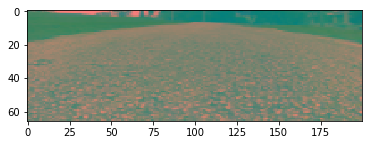

In [3]:
raw_X, raw_y = import_data('../loop1')
print('Images loaded.')
print('Processing images..')
raw_X = np.array([process_image(item) for item in raw_X])
raw_X = normalize(raw_X)
print('X shape: ', raw_X.shape)
print('y shape: ', raw_y.shape)
imshow(raw_X[0])

In [4]:
shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [5]:
train_X, train_y, val_X, val_y, test_X, test_y = split_data(shuffled_X, shuffled_y, 0.8, 0.1)

print('Train: ', len(train_X))
print('Validation: ', len(val_X))
print('Test: ', len(test_X))
print('Total: ', len(train_X) + len(val_X) + len(test_X))

Train:  10726
Validation:  1340
Test:  1342
Total:  13408


In [ ]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D, Activation, Dropout, Dense, Flatten

Using TensorFlow backend.


# Udacity SDC Model

In [7]:
model = Sequential()

#model.add(Lambda(lambda x: lamb(x), input_shape=(93, 160, 3)))

model.add(Convolution2D(24, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal', input_shape=(66, 200, 3)))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(36, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(48, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), strides=(1,1), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), strides=(1,1), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(100, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(Dense(50, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(Dense(10, kernel_initializer='he_normal'))
model.add(Activation('elu'))


model.add(Dense(1, kernel_initializer='he_normal'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
activation_3 (Activation)    (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
__________

# Train

In [8]:
from keras import callbacks
model_path = os.getcwd() + '/models/ud_sidewalk.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [10]:
model.fit(train_X, train_y, batch_size=32, epochs=10, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 10726 samples, validate on 1340 samples
Epoch 1/10
10726/10726 [==============================] - 88s - loss: 0.0058 - val_loss: 0.0049
Epoch 2/10
10726/10726 [==============================] - 88s - loss: 0.0051 - val_loss: 0.0051
Epoch 3/10
10726/10726 [==============================] - 88s - loss: 0.0051 - val_loss: 0.0053
Epoch 4/10
10726/10726 [==============================] - 89s - loss: 0.0049 - val_loss: 0.0048
Epoch 5/10
10726/10726 [==============================] - 87s - loss: 0.0048 - val_loss: 0.0050
Epoch 6/10
10726/10726 [==============================] - 87s - loss: 0.0047 - val_loss: 0.0046
Epoch 7/10
10726/10726 [==============================] - 88s - loss: 0.0045 - val_loss: 0.0052
Epoch 8/10
10726/10726 [==============================] - 90s - loss: 0.0044 - val_loss: 0.0044
Epoch 9/10
10726/10726 [==============================] - 91s - loss: 0.0043 - val_loss: 0.0049
Epoch 10/10
10726/10726 [==============================] - 94s - loss: 0.0042 - val_los

# Evaluate

In [11]:
import pandas as pd
from keras.models import load_model
model_path = os.getcwd() + '/models/udacity_model.hdf5'
model = load_model(model_path)

# Test Data

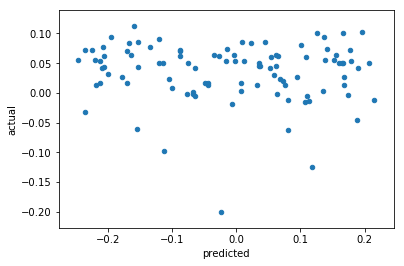

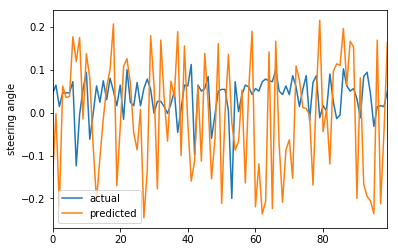

In [14]:
pred_y = model.predict(test_X[:100])
pred_y = pred_y.reshape((pred_y.shape[0],))
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y[:100]})
ax = df.plot.scatter('predicted', 'actual')
ax2 = pd.DataFrame({'predicted':pred_y, 'actual':test_y[:100]}).plot()
ax2.set_ylabel('steering angle')

# Training Data

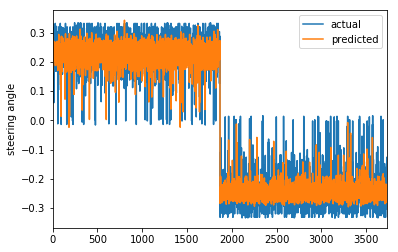

In [36]:
pred_y_2 = model.predict(train_X)
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':train_y}).plot()
ax.set_ylabel('steering angle')

In [37]:
print(model.predict(train_X[1:2]))

[[ 0.29172346]]


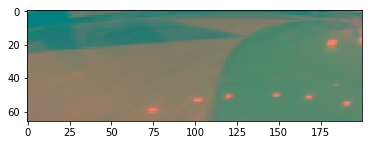

In [38]:
imshow(train_X[1])